In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [13]:
data=pd.read_csv('dataset/user_subset.csv')
data.head()

,Unnamed: 0,Usr,Song,Time
0,630,5a905f000fc1ff3df7ca807d57edb608863db05d,SOEBCBI12AF72A154F,5
1,658,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1
2,670,5a905f000fc1ff3df7ca807d57edb608863db05d,SOGJPMB12A8C13A9DB,1
3,919,5a905f000fc1ff3df7ca807d57edb608863db05d,SOUCKDH12A8C138FF5,2
4,1005,5a905f000fc1ff3df7ca807d57edb608863db05d,SOZOEYP12AB0188C9D,2


In [14]:
# label编码
user_encoder = LabelEncoder()
data['Usr'] = user_encoder.fit_transform(data['Usr'].values)

song_encoder = LabelEncoder()
data['Song'] = song_encoder.fit_transform(data['Song'].values)


# 数据类型转换
data.astype({'Usr': 'int32', 'Song': 'int32', 'Time': 'int32'})

,Unnamed: 0,Usr,Song,Time
0,630,8021,519,5
1,658,8021,679,1
2,670,8021,804,1
3,919,8021,2354,2
4,1005,8021,2897,2
...,...,...,...,...
151052,48373339,11587,1642,1
151053,48373364,11587,1951,1
151054,48373382,11587,2202,1
151055,48373405,11587,2354,2


In [15]:
# 用户的歌曲播放总量的分布
# 字典user_playcounts记录每个用户的播放总量
user_playcounts = {}
for user, group in data.groupby('Usr'):
    user_playcounts[user] = group['Time'].sum()

/Users/yaqianchen/miniconda3/envs/MLFINAL/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


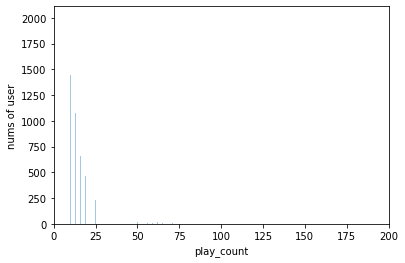

In [16]:
# 作图
sns.distplot(list(user_playcounts.values()), bins=5000, kde=False)
plt.xlim(0, 200)
plt.xlabel('play_count')
plt.ylabel('nums of user')
plt.show()

In [17]:
temp_user = [user for user in user_playcounts.keys() if user_playcounts[user] > 100]
temp_playcounts = [playcounts for user, playcounts in user_playcounts.items() if playcounts > 100]

print('歌曲播放量大于100的用户数量占总体用户数量的比例为', str(round(len(temp_user)/len(user_playcounts), 4)*100)+'%')
print('歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(user_playcounts.values())*100, 4))+'%')
print('歌曲播放量大于100的用户产生的数据占总体数据的比例为', str(round(len(data[data.Usr.isin(temp_user)])/len(data)*100, 4))+"%")

歌曲播放量大于100的用户数量占总体用户数量的比例为 0.25%
歌曲播放量大于100的用户产生的播放总量占总体播放总量的比例为 2.5189%
歌曲播放量大于100的用户产生的数据占总体数据的比例为 0.3509%


In [18]:
# # 过滤掉歌曲播放量少于100的用户的数据
# data = data[data.Usr.isin(temp_user)]

In [19]:
# song_playcounts字典，记录每首歌的播放量
song_playcounts = {}
for song, group in data.groupby('Song'):
    song_playcounts[song] = group['Time'].sum() 

/Users/yaqianchen/miniconda3/envs/MLFINAL/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


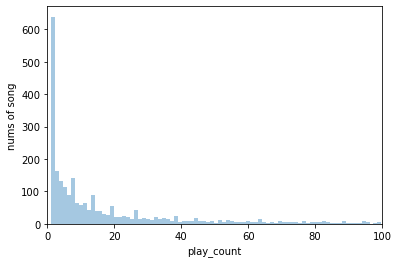

In [20]:
# 作图
sns.distplot(list(song_playcounts.values()), bins=10000, kde=False)
plt.xlim(0, 100)
plt.xlabel('play_count')
plt.ylabel('nums of song')
plt.show()

In [21]:
temp_song = [song for song in song_playcounts.keys() if song_playcounts[song] > 50]
temp_playcounts = [playcounts for song, playcounts in song_playcounts.items() if playcounts > 50]

print('播放量大于20的歌曲数量占总体歌曲数量的比例为', str(round(len(temp_song)/len(song_playcounts), 4)*100)+'%')
print('播放量大于20的歌曲产生的播放总量占总体播放总量的比例为', str(round(sum(temp_playcounts) / sum(song_playcounts.values())*100, 4))+'%')
print('播放量大于20的歌曲产生的数据占总体数据的比例为', str(round(len(data[data.Song.isin(temp_song)])/len(data)*100, 4))+"%")

播放量大于20的歌曲数量占总体歌曲数量的比例为 25.83%
播放量大于20的歌曲产生的播放总量占总体播放总量的比例为 93.1001%
播放量大于20的歌曲产生的数据占总体数据的比例为 92.287%


In [22]:
# # 过滤掉播放量小于50的歌曲
# data = data[data.Song.isin(temp_song)]

In [23]:
user_averageScore = {}
for Usr, group in data.groupby('Usr'):
    user_averageScore[Usr] = group['Time'].mean()

In [24]:
data['rating'] = data.apply(lambda x: np.log(2 + x.Time / user_averageScore[x.Usr]), axis=1)

/Users/yaqianchen/miniconda3/envs/MLFINAL/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


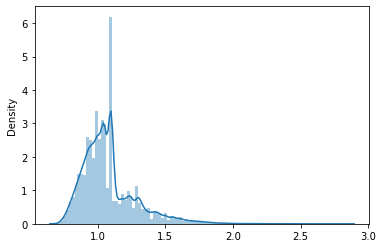

In [25]:
sns.distplot(data['rating'].values, bins=100)
plt.show()

In [26]:
user_item_rating = data[['Usr', 'Song', 'rating']]
user_item_rating = user_item_rating.rename(columns={'Song': 'item'})

In [27]:
#用户听过的歌曲集合
user_songs = {}
for user, group in user_item_rating.groupby('Usr'):
    user_songs[user] = group['item'].values.tolist()

# 歌曲集合
songs = user_item_rating['item'].unique().tolist()

In [28]:
user_item_rating.head()

,Usr,item,rating
0,8021,519,1.452252
1,8021,679,0.897942
2,8021,804,0.897942
3,8021,2354,1.067841
4,8021,2897,1.067841


In [29]:

# userCF

# 阅读器
reader = Reader(line_format='user item rating', sep=',')
# 载入数据
raw_data = Dataset.load_from_df(user_item_rating, reader=reader)
# 分割数据集
kf = KFold(n_splits=2)
# 构建模型
knn_usercf = KNNBasic(k=40, sim_options={'user_based': True})
# 训练数据集，并返回rmse误差
# knn_usercf.fit(raw_data)
print(type(raw_data))
for trainset, testset in kf.split(raw_data):
    print(type(trainset))
    knn_usercf.fit(trainset)
#     predictions = knn_usercf.test(testset)
#     accuracy.rmse(predictions, verbose=True)

<class 'surprise.dataset.DatasetAutoFolds'>
<class 'surprise.trainset.Trainset'>
Computing the msd similarity matrix...
Done computing similarity matrix.
<class 'surprise.trainset.Trainset'>
Computing the msd similarity matrix...
Done computing similarity matrix.


In [36]:
# userCF 推荐
def recommendation_basedonUserCF(userID, N=5):
    # 用户听过的音乐列表
    used_items = user_songs[userID]
    
    # 用户对未听过音乐的评分
    item_ratings = {}
    for item in songs:
        if item not in used_items:
            item_ratings[item] = knn_usercf.predict(userID, item).est
    
    # 找出评分靠前的5首歌曲
    song_ids = dict(sorted(item_ratings.items(), key=lambda x: x[1], reverse=True)[:N])
    
    return list(song_ids.keys())

recommendation_basedonUserCF(8021)

[158, 2012, 1675, 182, 1082]

In [ ]:
# test_case = ["d7083f5e1d50c264277d624340edaaf3dc16095b", "0b254c684efb08fd04933add2d1e4191d2a87bac", "eda9bc7bcd72d18b9cf964990eb13a5b1789e78f", "05b9035fe02ebdf5535ae9ec07de1e935ffa43df", "4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5"]
# test_data=pd.read_table('dataset/evaluation_answer.txt', delimiter = '\t')
# test_data.head()

In [ ]:
# test_case_item = {}
# for _, i in test_data.iterrows():
#     if i["Usr"] in test_case_item:
#         test_case_item[i["Usr"]].append(i["Song"])
#     else:
#         test_case_item[i["Usr"]] = [i["Song"]]
# acc = 0
# for usr in test_case:
#     predict_songs = recommendation_basedonUserCF(usr)
#     for predict_song in predict_songs:
# #         print(predict_song)
# #         print(test_case_item[usr])
#         if predict_song in test_case_item[usr]:
#             acc = acc + 1
# acc/(len(test_case) * 5) 